# <span style="color:orange"> Exercise 4 </span>
### Exercise 4.1
## <span style="color:green"> Task </span>
The Molecular Dynamics (MD) code starts the simulation run from a provided spatial configuration of the $N$ particles (file: <font face="Courier">config.0</font>) and, once the simulation is finished, it writes out the final configuration (file: <font face="Courier">config.final</font>). 
1. <span style="color:red">Improve the MD code by enabling (you should insert this option via a boolean-like variable in the input file) the **possibility** to **(re)start** reading not only a **actual** spatial configuration [$\vec{r}(t)$] file but also an **old** spatial configuration [$\vec{r}(t-dt)$] file</span> (files: <font face="Courier">old.0</font> and <font face="Courier">old.final</font>).
2. Moreover, <span style="color:red">add the possibility to rescale the velocities [i.e. to correct $\vec{r}(t-dt)$] in order to match a desired temperature</span>.
3. In your report, put some pictures which show that you have been able to equilibrate the thermodynamic phases at the beginning of your simulations.

The typical required operations when the re-start option will be enabled are:
1. read $\vec{r}(t)$ and $\vec{r}(t-dt)$ from the corresponding input files
2. compute $\vec{r}(t+dt)$ with one step of the Verlet algorithm; with $\vec{r}(t+dt)$ and $\vec{r}(t)$ compute $\vec{v}(t+dt/2)$; finally obtain the actual temperature $T(t+dt/2)$
3. by comparing $T(t+dt/2)$ with the desired/target temperature  $T^\star$ extract a scaling factor for the velocities and rescale them: $\vec{v}(t) \to \vec{v}_s(t)$
4. use $\vec{v}_s(t)$ to estimate a novel **old** spatial configuration: $\vec{r}_{new}(t) = \vec{r}(t+dt) - dt \vec{v}_s$
5. use $\vec{r}_{new}(t)$ and $\vec{r}(t+dt)$ to start the simulation
6. Do not forget to use **periodic boundary contitions** every time it is appropriate!

## <span style="color:green"> Solution </span>
The objective of this exercise is to find a way to equilibrate a given set of particles inside a system, in order to solve Newton's law of motion until the properties of the system no longer change.
A single simulation loads 108 particles from a configuration that is determined by the restart parameter, which is passed by command line to the main.cpp file. If restart = 0, the simulation is run for the first time and it initializes with the spacial configuration defined in the file "config.0", while if "restart > 0", the configuration is declared in the file config.final, which is the final particle arrangement of the previous simulation. An additional parameter ```<equilibration_run>``` is passed from command-line, to decide whether the simulation is equilibrating the system by adjusting the velocities by a scale factor, or whether the system has reached equilibrium and the macroscopic properties can be finally quested.

A certain number of simulations are executed for each state of matter, as shown inside the run.py script. For each state of matter the number of simulations varies, because it is expected for gaseous states to equilibrate in longer periods of time. <br>
The expectation is that the temperature will progressively converge because of the continuous tweaking and rescaling of the initial velocities for the equilibrium quest.

In order to compare my results with other data, I decided to calculate the same macroscopic variable for Argon as well as for Krypton, since I was aware of the possibility to use different elements, although it was not requested. In fact, another reason was to demostrate that the Lennard-Jones units are not bounded to one element, but different elements can be sampled by the same LJ units.

This section focuses on showing the results of the equilibration of the system.

In [1]:
import numpy as np
import sys, os
import re
from rich.console import Console
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import pacf, acf
c = Console()

def read_temp(state:str):
    lines = open(f"4.4/input_files/{state}.ini","r+").read().split("\n")
    for l in lines:
        if l.startswith("temp"):
            x = re.findall(r"[-+]?\d*\.?\d+|\d+",l)[0]
            return float(x)
    return None

def read_integrationstep(state):
    lines = open(f"4.4/input_files/{state}.ini","r+").read().split("\n")
    for l in lines:
        if l.startswith("delta"):
            x = re.findall(r"[-+]?\d*\.?\d+|\d+",l)[0]
            return float(x)
    return None


baseoutputdir = "4.4/outputs/"
elements = ("argon","krypton")
states = ("solid","liquid","gas")
variables = (("ekin","Kinetic Energy","J"),("epot","Potential Energy","J"),("etot","Total Energy","J"),("temp","Temperature","K"),("pres","Pressure","Pa"))
expected_temps = np.array([read_temp(state) for state in states])
deltas = np.array([read_integrationstep(state) for state in states])


# Physical constants in SI units (arbitrarily approximated...)
boltzmann_constant = 1.381e-23
atomic_mass_unit = 1.661e-27

# Unit scales
length      = {"argon" : 0.34e-9,                   "krypton" : 0.364e-9}
energy      = {"argon" : 120 * boltzmann_constant,  "krypton" : 164 * boltzmann_constant}
mass        = {"argon" : 39.948 * atomic_mass_unit, "krypton" : 83.798 * atomic_mass_unit}

The following section shows the measurement of each macroscopic property of the system at a state of equilibrium. In fact, as mentioned earlier, after numerous runs to bring the system to equilibrium, the velocities are no longer scaled and the datablocking technique is used to find the averages of the variables as a function of the step taken, or the time passed. Each variable is plotted together with the final value to have a value of reference for the trend.

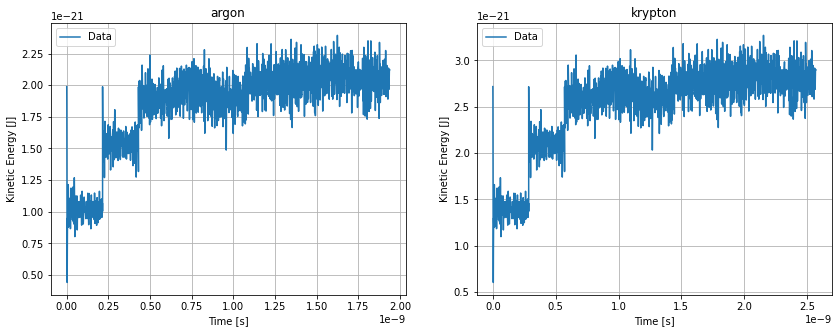

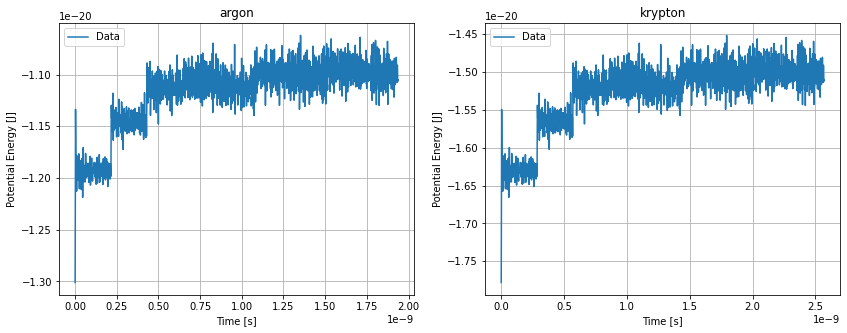

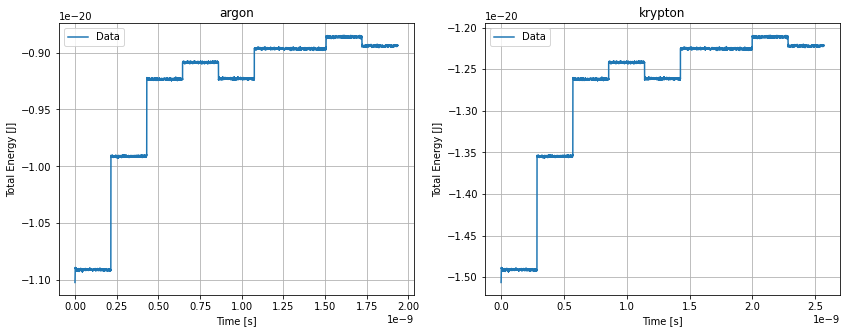

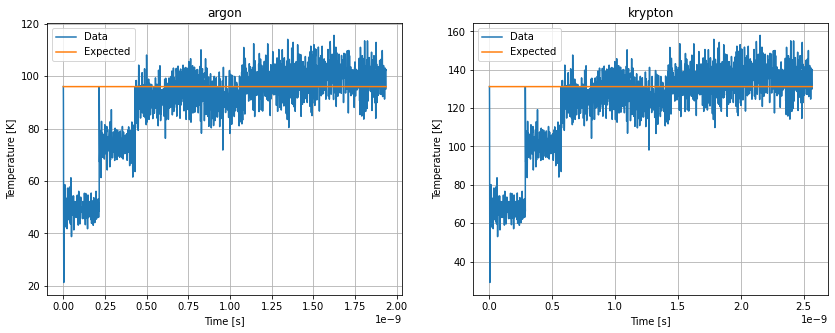

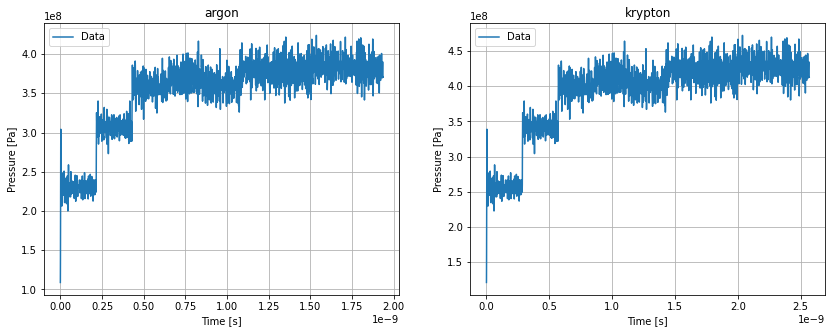

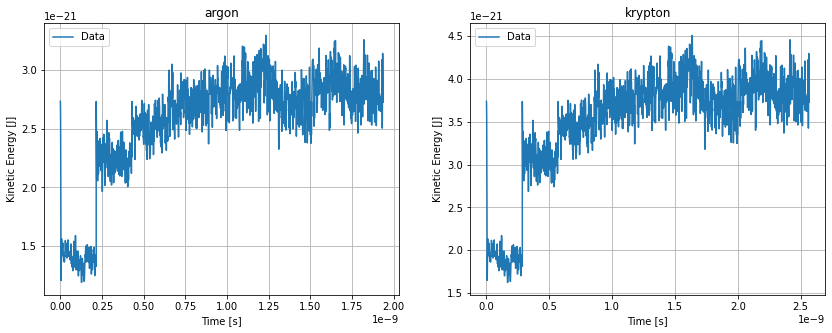

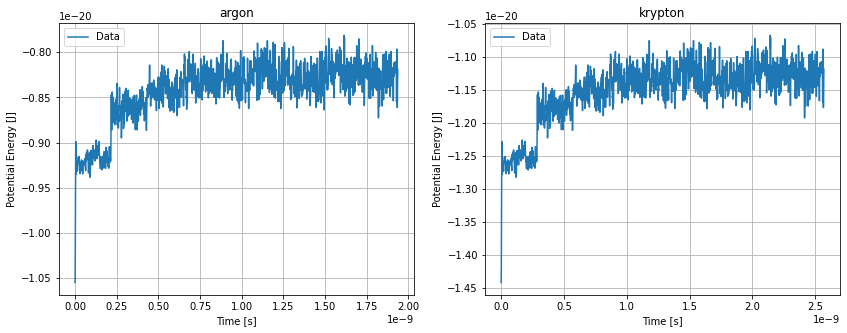

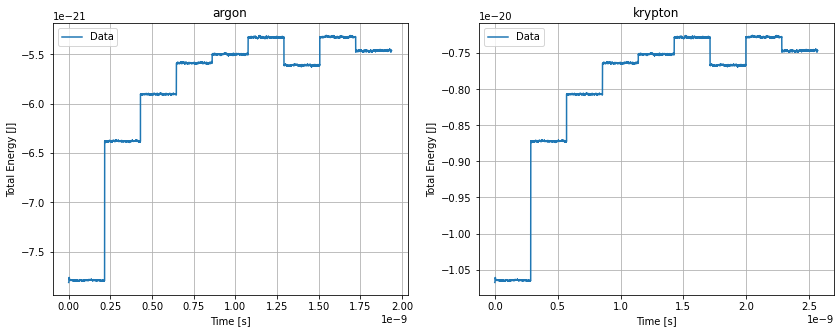

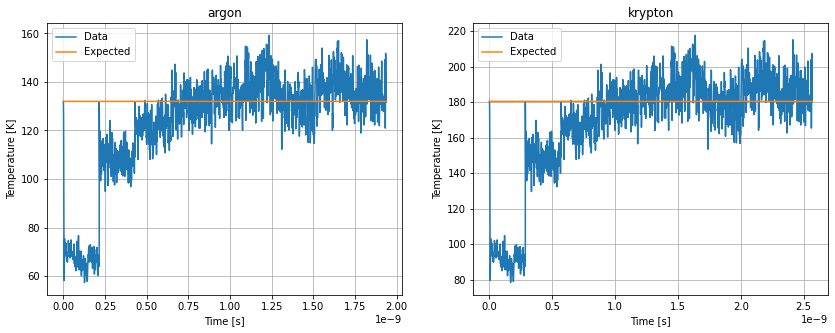

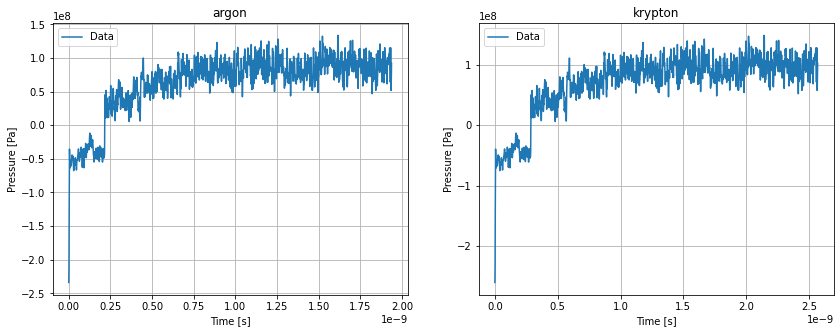

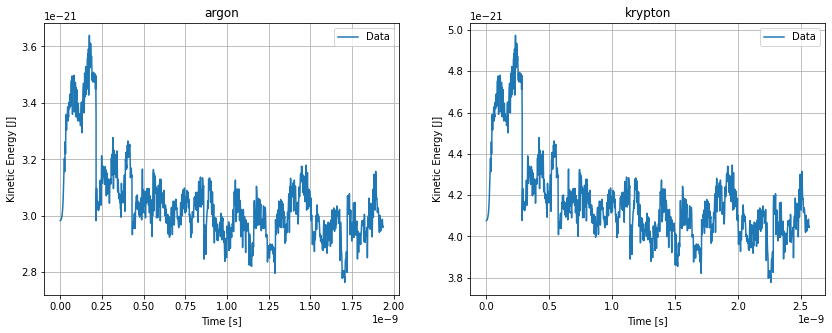

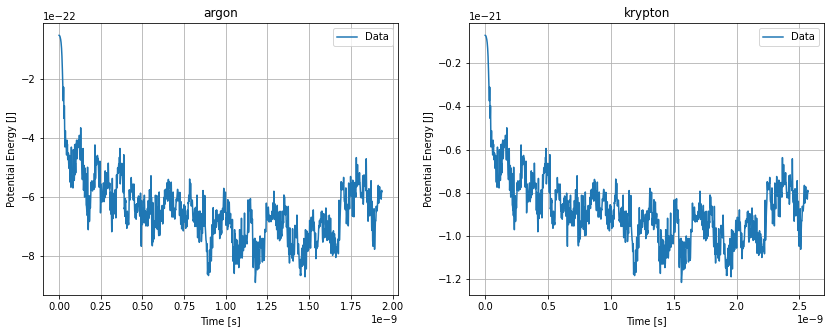

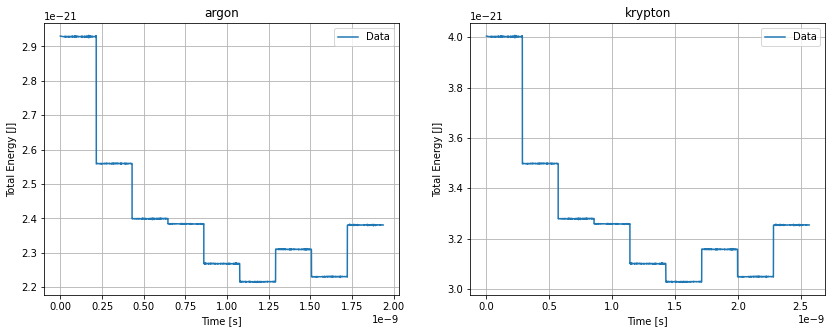

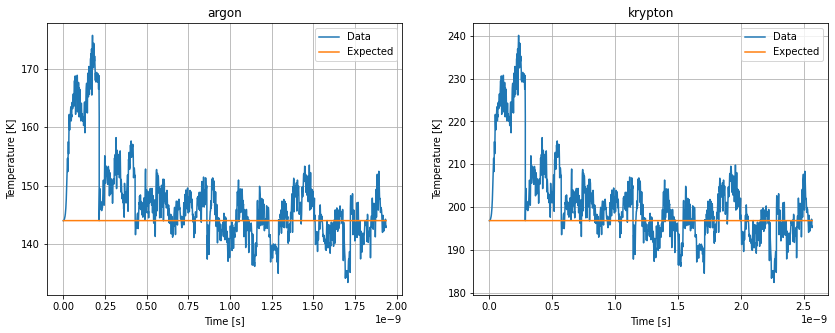

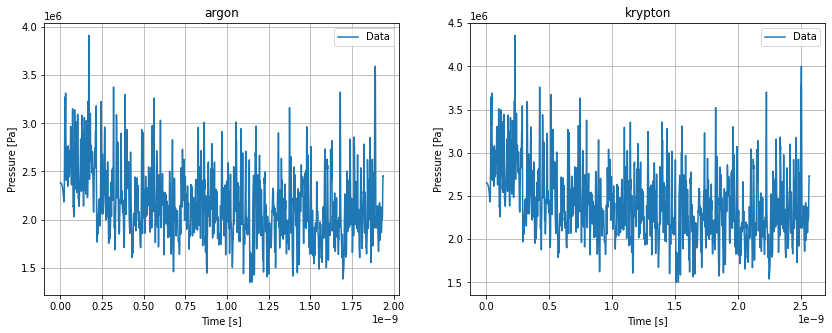

In [2]:
c.print("##################################  EQUILIBRATION PHASE  ##################################",style="bold red on white", justify="center")
for i1, state in enumerate(states):
    c.print(f"============  {state.capitalize()}  ============\n", style="bold blue on white", justify="center")
    for i2, v in enumerate(variables):
        fig, ax = plt.subplots(1,2,figsize=(14,5))
        for i3, elem in enumerate(elements):
            if v[0]=="temp":
                SI_unit = energy[elem] / boltzmann_constant
            elif v[0]=="pres":
                SI_unit = energy[elem] * length[elem]**(-3)
            else:
                SI_unit = energy[elem]
            time = np.sqrt(mass[elem] * length[elem]**2 / energy[elem])
            val = np.loadtxt(baseoutputdir+state+"/equilibration/instant_"+v[0]+".dat", unpack=True)
            i = np.array([i for i in range(len(val))])
            ax[i3].set_title(elements[i3])
            ax[i3].set_xlabel("Time [s]")
            ax[i3].set_ylabel(f"{v[1]} [{v[2]}]")
            ax[i3].plot(time * deltas[i1] * i,val*SI_unit, label="Data")
            if (v[0]=="temp"):
                exp = [expected_temps[i1]*SI_unit for i in range(len(val))]
                ax[i3].plot(time * deltas[i1] * i, exp, label="Expected")
            ax[i3].grid(True)
            ax[i3].legend()
        plt.show()
    print("\n\n")

<br>Here, the results of the datablocking methods are shown in order to graph the average of each variable, for each state of matter. As mentioned, the datablocking has been calculated only on the instantaneous values obtained from a measurement run, where the scale factor for the velocities has not been included, in order to maintain the system in a state of equilibrium.

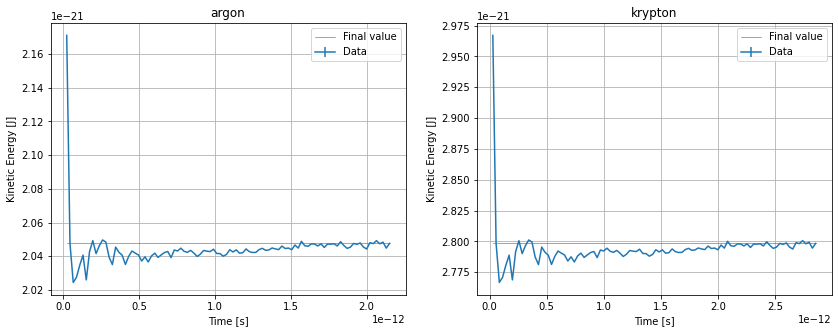

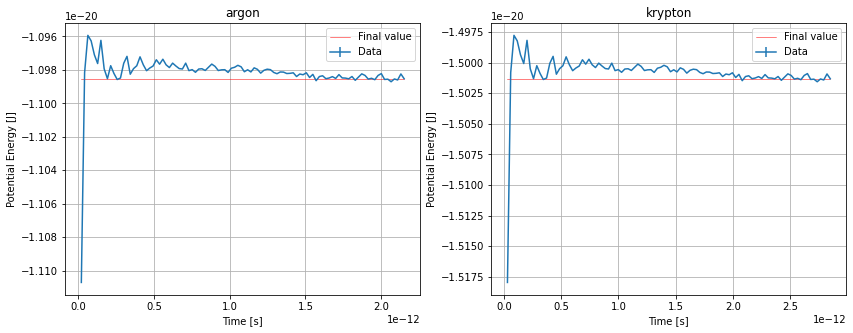

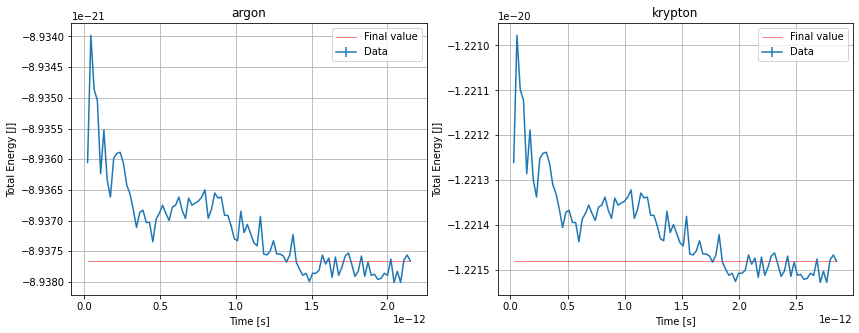

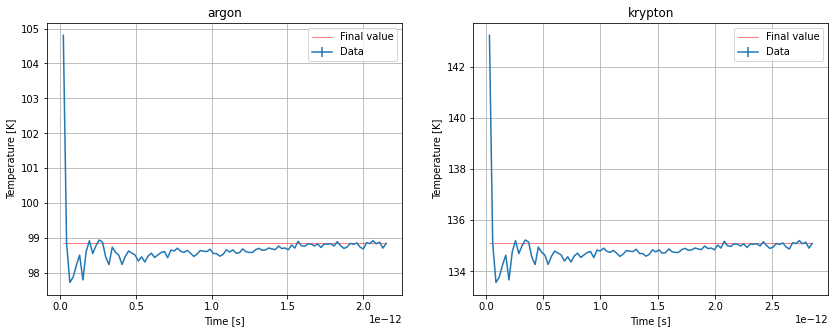

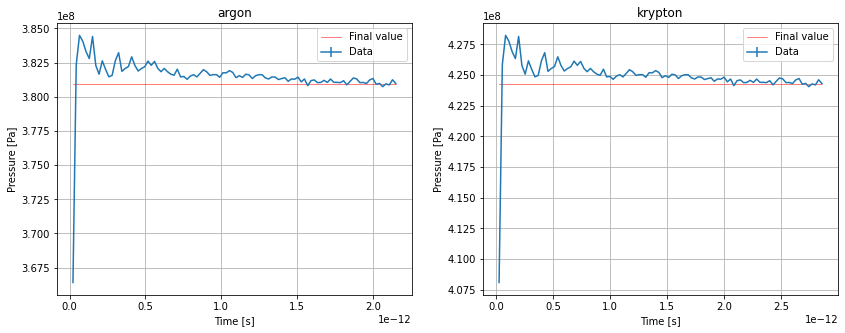

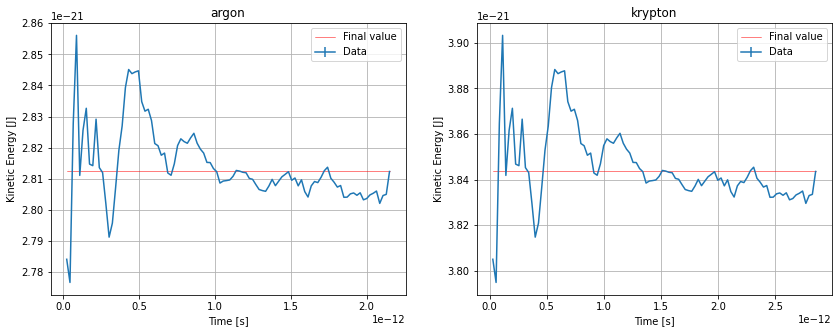

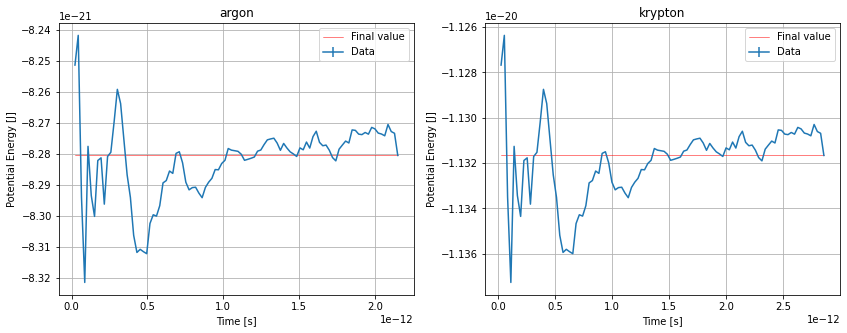

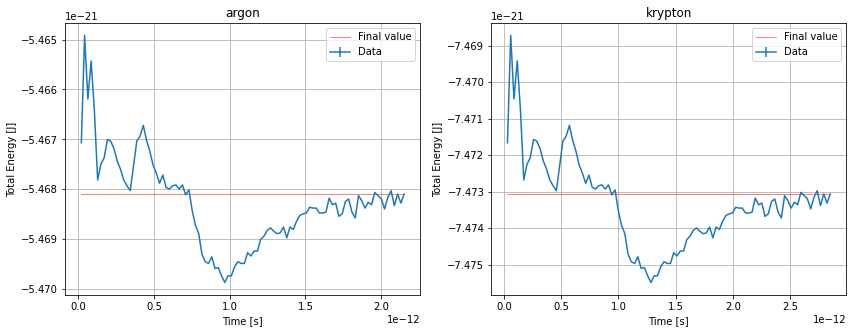

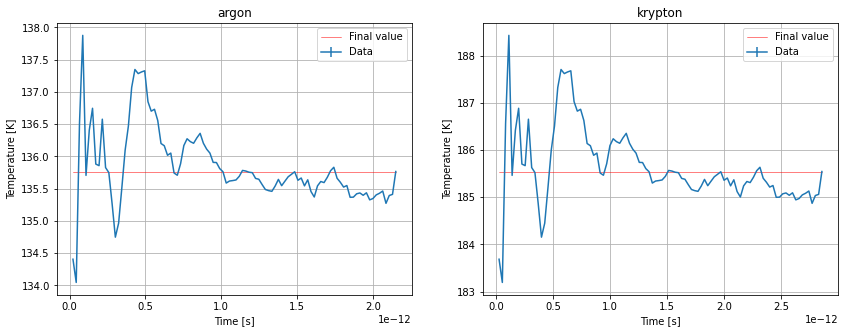

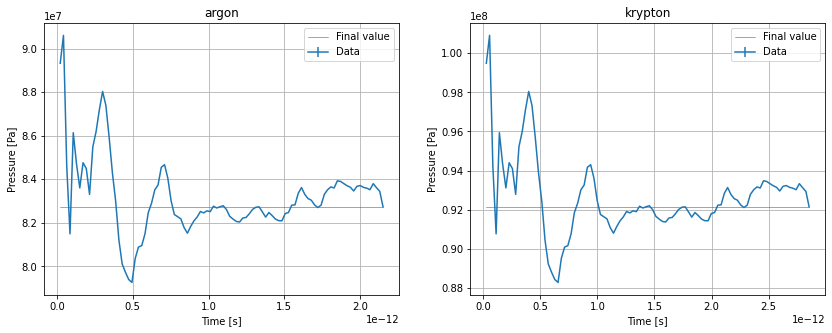

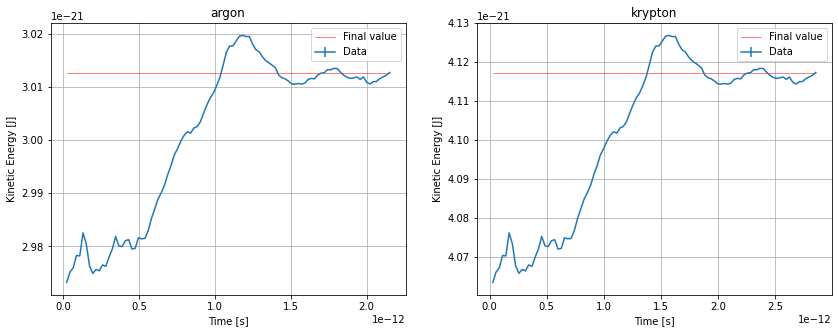

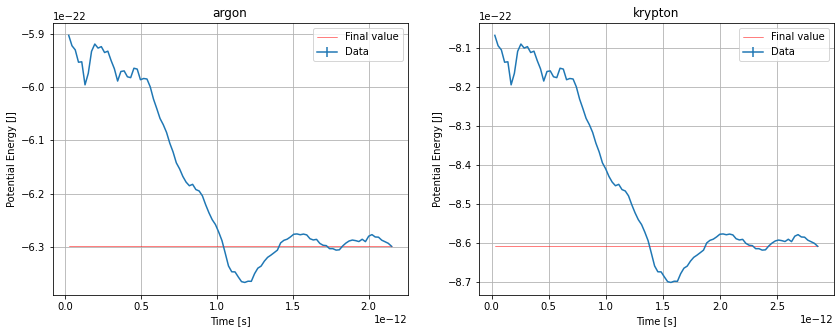

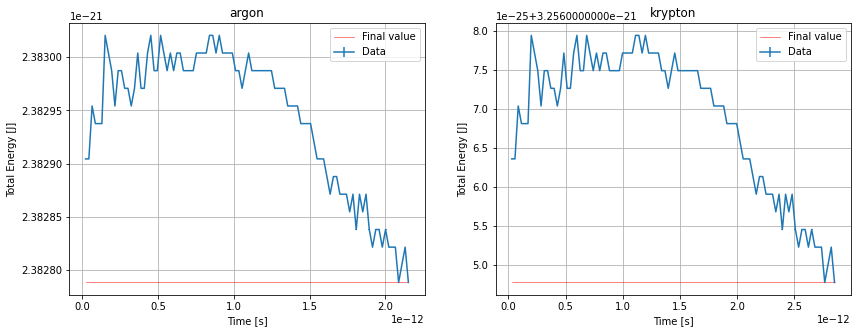

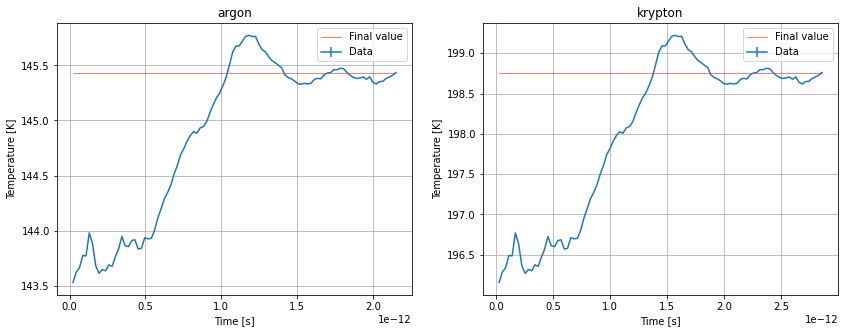

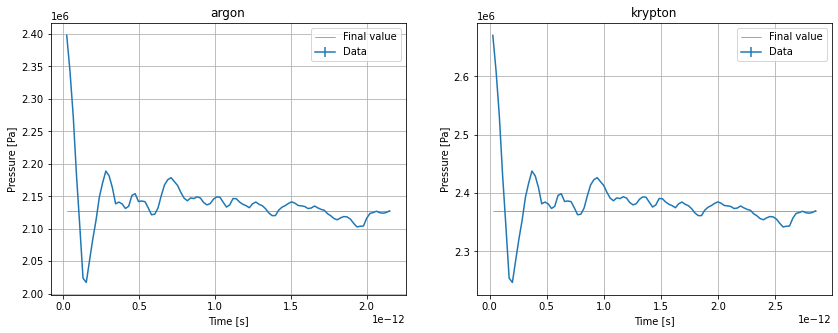

In [5]:
c.print("##################################  MEASUREMENT PHASE  ##################################",style="bold red on white", justify="center")
for i1, state in enumerate(states):
    c.print(f"============  {state.capitalize()}  ============\n", style="bold blue on white", justify="center")
    for i2, v in enumerate(variables):
        fig, ax = plt.subplots(1,2,figsize=(14,5))
        for i3, elem in enumerate(elements): 
            if v[0]=="temp":
                SI_unit = energy[elem] / boltzmann_constant
            elif v[0]=="pres":
                SI_unit = energy[elem] * length[elem]**(-3)
            else:
                SI_unit = energy[elem]
            time = np.sqrt(mass[elem] * length[elem]**2 / energy[elem])
            i, y, err = np.loadtxt(baseoutputdir+state+"/measurements/ave_"+v[0]+".dat", unpack=True)
            ax[i3].set_title(elements[i3])
            ax[i3].set_xlabel("Time [s]")
            ax[i3].set_ylabel(f"{v[1]} [{v[2]}]")
            ax[i3].errorbar(time * deltas[i1] * i,y*SI_unit, yerr = err*SI_unit, label="Data")
            ax[i3].plot(time*deltas[i1]*i,[y[-1]*SI_unit for k in range(len(i))], label="Final value", linewidth = 0.5, color="red")
            ax[i3].grid(True)
            ax[i3].legend()
        plt.show()
    print("\n\n")

## <span style="color:green"> Results </span>
The progressive averages converge to a discrete value as expected, thanks to the datablocking method. The temperatures also converge to the expected values which are known a priori. However, even after numerous attempts, the datablocking method for this exercise refused to properly calculate the statistical uncertainties for each block. Since the associated error is fundamental in MonteCarlo simulations, I would suggest that the error bars for each graph would be quite big for small numbers of blocks (time passed) as expected from the datablocking method, while for increasing time the error should decrease around the value of convergence.